http://preview.d2l.ai/d2l-en/master/chapter_generative-adversarial-networks/gan.html

In [1]:
%matplotlib inline
from d2l import tensorflow as d2l
import tensorflow as tf

https://www.tensorflow.org/api_docs/python/tf/random/normal

https://www.tensorflow.org/api_docs/python/tf/norm

In [2]:
X = d2l.normal([1000, 2], 0.0, 1, tf.float32)

In [3]:
A = d2l.tensor([[1, 2], [-0.1, 0.5]], tf.float32)
b = d2l.tensor([1, 2], tf.float32)
data = d2l.matmul(X, A) + b

The covariance matrix is
[[1.01 1.95]
 [1.95 4.25]]


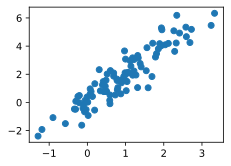

In [4]:
d2l.set_figsize()
d2l.plt.scatter(d2l.numpy(data[:100, 0]), d2l.numpy(data[:100, 1]));
print(f'The covariance matrix is\n{d2l.matmul(tf.transpose(A), A)}')

In [5]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

In [7]:
net_G = tf.keras.Sequential()
net_G.add(tf.keras.layers.Dense(2))

In [9]:
net_G = tf.keras.Sequential()
net_G.add(tf.keras.layers.Dense(2))

In [ ]:
net_D = tf.keras.Sequential()
tf.keras.Sequential()nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))